# Advanced options

In the previous lesson we learned about the basic and intermediate options of Tensor Fox. For most of applications this is enough, but sometimes one needs to change more parameters, add constraints, and so on. In this lesson we also cover the options regarding higher order tensors. Warning: this lesson have a more mathematical flavour.

Options already covered:

    display
    maxiter  
    tol     
    trunc_dims
    level
    init_method
    refine    
    init_damp
    symm    
    
Options to be covered:

    method 
    method_maxiter 
    method_tol 
    constraints 
    trials 
    bi_method
    bi_method_maxiter 
    bi_method_tol 
    epochs 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import TensorFox as tfx
from IPython.display import Image

In [2]:
# Create the tensor.
m = 2
T = np.zeros((m, m, m))
s = 0

for k in range(m):
    for i in range(m):
        for j in range(m):
            T[i,j,k] = s
            s += 1

# Inner algorithm options

The method we are using to solve the problem of tensor approximation is called *damped Gauss-Newton* (dGN), and at each step tof this method the program needs to solve a equation of the form

$$(J^T J + \mu D) x = J^Tb$$
as already mentioned. To solve this equation we have to rely on other method, which can be the [conjugate gradient](https://en.wikipedia.org/wiki/Conjugate_gradient_method) method (default) os the [LSMR](http://web.stanford.edu/group/SOL/software/lsmr/) (least squares with minimal residuals) method. These method also have their own parameters, and the user may have to tune them for its own purposes. With this in mind, Tensor Fox offers the parameters *method, method_maxiter, method_tol* for the user. They are explained below.

The options are 'cg', 'cg_static', 'lsmr', 'lsmr_static' and 'als'. The difference between static and non-static versions are the way the program deals with the maximum number of iteration. The static algorithms have a certain maximum number of iterations which are fixed during all the program. This number is the parameter *method_maxiter* (the method 'als' is always static). The non-static (random or dynamic) versions uses the parameter *method_maxiter* in a different way. They can have different maximum number of iterations depending on the current iteration of the dGN. More precisely, if the program is at the $k$-th iteration of the dGN, then the maximum number of iteration permitted by the inner algorithm (cg or lsmr) is
 
$$1 + \verb|int|\left( \verb|method|\_\verb|maxiter| \cdot \verb|randint|\left( 1 + k^{0.4}, 2 + k^{0.9} \right) \right).$$

For the methods 'cg' and 'lsmr', the default is *method_maxiter = 1*, which means the default is to use the value

$$1 + \verb|randint|\left( 1 + k^{0.4}, 2 + k^{0.9} \right).$$

This strange interval of random integers were obtained after a lot of tests, a lot! This seems to be a robust choice, but since we can't be right all the time, the parameter *method_maxiter* comes to the rescue. If the number permitted of iterations are increasing too much, just set *method_maxiter* to a low value such as $0.1$ or $0.5$. The parameter *method_tol*, as the name suggests, is the tolerance parameter for the inner algorithm. The default for this value is to be equal than the tolerance of the dGN. Below we show an example of the usage of different inner algorithms.

In [3]:
# First we forget about constraints.
class options:
    low = 0
    upp = 0
    factor = 0
# Let's use LSMR static as the inner algorithm, with 3 iteratins max and tolerance of 0.001.
options.method = 'lsmr_static'
options.method_maxiter = 3
options.method_tol = 0.001
# We want to see how each iteration performs.
options.display = 2

r = 3
factors, T_approx, output = tfx.cpd(T, r, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    No compression detected
    Working with dimensions (2, 2, 2)
-----------------------------------------------------------------------------------------------
Type of initialization: random
-----------------------------------------------------------------------------------------------
Computing CPD
    Iteration | Rel error | Improvement | norm(grad) | Predicted error | # Inner iterations
        1     | 6.69e+00  |  6.69e+00   |  6.58e-01  |    2.19e+00     |        3        
        2     | 1.58e+00  |  5.11e+00   |  5.73e-01  |    2.60e+00     |        3        
        3     | 4.04e-01  |  1.17e+00   |  5.55e-01  |    1.91e+00     |        3        
        4     | 1.96e-01  |  2.08e-01   |  6.61e-01  |    1.70e+00     |        3        
        5     | 2.59e-01  |  6.24e-02   |  6.31e-01  |    1.33e+00     |        3        
        6     | 2.73e-01  |  1.39e-02   |  

# Constraints

*low, upp, factor*, these three parameters always work together. Their are used when the user want to add constraints to the tensor entries. More precisely, they produce a solution $T_{approx}$ such that each of its entries are inside the interval $[\verb|low|, \verb|upp|]$. Here is how it works, given the $k$-th approximation $T_{approx}^{(k)}$, denote by $t$ an arbitrary entry of $T_{approx}^{(k)}$. Before computing the $(k+1)$ iteration the program projects each entry $t$ in $[\verb|low|, \verb|upp|]$ through the map
$$t \mapsto \verb|low| + \frac{\verb|upp| - \verb|low|}{1 + e^{-A -Bt}},$$
where
$$A = -B \cdot \frac{\verb|low| + \verb|upp|}{2},$$
$$B = \ln\left( \frac{\verb|upp| - \verb|low|}{\varepsilon} - 1 \right) - \ln\left( \verb|factor| \cdot \frac{\verb|upp| - \verb|low|}{2} - \varepsilon \right),$$
and $\varepsilon > 0$ is small enough (currently we are using $\varepsilon = 0.02$).

This map is the sigmoid function with some specific constants, both depending on the parameter $\verb|factor|$, which is responsible for the stretching level of the curve. This sigmoid maps $\frac{\verb|low| + \verb|upp|}{2}$ as fixed point (it is located at the 'center' of the function) and it has $\verb|low|$ and $\verb|upp|$ as horizontal asymptotes. Below we show nine plots illustrating the behavior of this map.

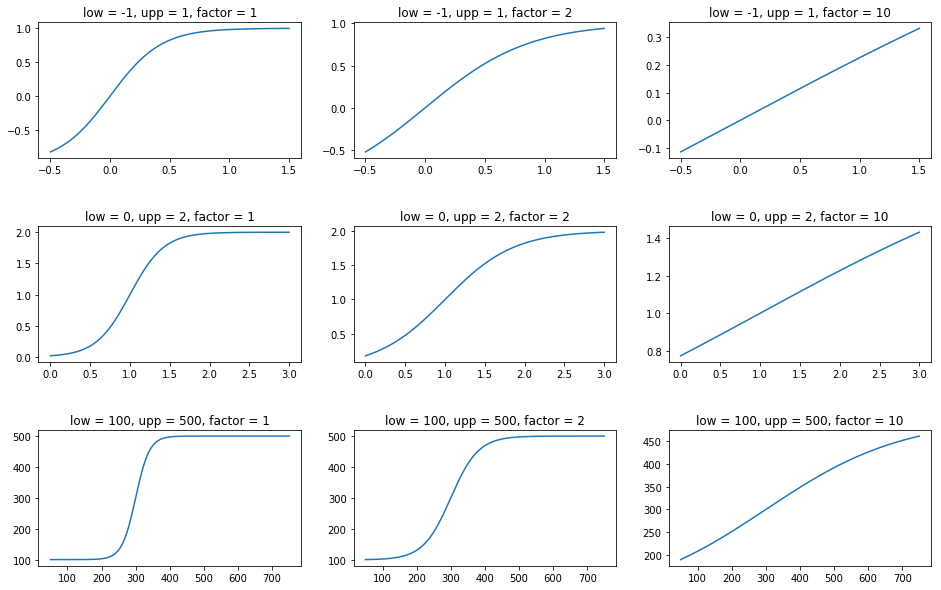

In [4]:
eps = 0.02
# Each entry of the list 'parameters' is a triple (low, upp, factor)
parameters = [[-1,1,1], 
              [-1,1,2], 
              [-1,1,10], 
              [0,2,1], 
              [0,2,2], 
              [0,2,10], 
              [100,500,1], 
              [100,500,2], 
              [100,500,10]]

k = 0
num_rows = 3
num_cols = 3    
fig, ax = plt.subplots(num_rows, num_cols, figsize=(16, 10))    
fig.subplots_adjust(hspace=0.5)
for i in range(num_rows):
    for j in range(num_cols):
        low, upp, factor = parameters[k][0], parameters[k][1], parameters[k][2]
        t = np.linspace(low - low/2, upp + upp/2, 1000)
        B = np.log( (upp-low)/eps - 1 )/( factor*(upp-low)/2 - eps )
        A = -B*(low+upp)/2
        y = low + (upp-low)/(1 + np.exp(-A-B*t))
        ax[i,j].title.set_text('low = ' + str(low) + ', upp = ' + str(upp) + ', factor = ' + str(factor))
        ax[i,j].plot(t, y)
        k += 1
plt.show()

In the example of this tutorial we know that all entries of $T$ are between $0$ and $7$, so we can try to constrain the CPD to this values. This may decrease the number of iterations since we are forcing all entries to be closer to their objective values. since this example is so simple, the difference is unnoticeable.

**PS:** the default is *low, upp, factor* $= 0,0,0$ which the program reads as 'don't use constraints'. If you are done with these constraints and don't want to use them anymore, just set each one to zero.

In [5]:
# CPD with constraints
r = 3

class options:
    display = 1
    low = 0
    upp = 7
    factor = 1
    
factors, T_approx, output = tfx.cpd(T, r, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    No compression detected
    Working with dimensions (2, 2, 2)
-----------------------------------------------------------------------------------------------
Type of initialization: random
-----------------------------------------------------------------------------------------------
Computing CPD
Final results
    Number of steps = 43
    Relative error = 2.7112148012244426e-05
    Accuracy =  99.99729 %


# Higher order tensors and the Tensor Train format

Tensor Fox has distinct approaches when it comes to computing the CPD of third order tensors and higher order tensors. For third order tensors the program relies on the *Damped Gauss-Newton* (dGN) method. For higher order tensors the program relies on the *Tensor Train format* (TT format), also called *Tensor Train decomposition*. Without going in too much details, we use a specific configuration of the TT format which can be obtained by computing several third order CPD's. More precisely, if $T$ is a tensor of order $L$, then we can compute a CPD for it by computing $L-2$ third order CPD's. Once we have the TT format of $T$, the CPD can also be computed. The figure below illustrate the representation of a tensor train associated to a tensor of order $L$.

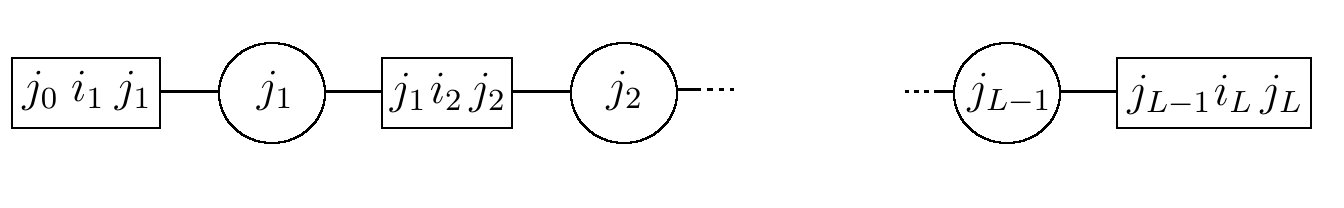

In [6]:
Image("tensor-train.png")

Each square represent the coordinates of a tensor and each circle is the coordinate with is shared between two consecutive tensors. These tensors are usually denoted by $\mathcal{G}^{(\ell)}$. For example, the second tensor is $\mathcal{G}^{(2)}$, which has coordinates $\mathcal{G}^{(\ell)}_{j_1 i_2 j_2}$, and the next tensor is $\mathcal{G}^{(3)}$, which has coordinates $\mathcal{G}^{(\ell)}_{j_2 i_3 j_3}$. The first and last tensor are acutally matrices (which mean $j_0 = j_L = 1$), and the other $L-2$ tensor are third order tensors. They are related to $T$ by the following formula:
$$T_{i_1 i_2 \ldots i_L} = \sum_{j_0, j_1, \ldots, j_L} \mathcal{G}^{(1)}_{j_0 i_1 j_1} \cdot \mathcal{G}^{(2)}_{j_1 i_2 j_2} \cdot \ldots \cdot \mathcal{G}^{(L)}_{j_{L-1} i_L j_L}.$$

By computing a CPD for $\mathcal{G}^{(2)}, \ldots, \mathcal{G}^{(L-1)}$ we can obtain a CPD for $T$.

## Trials

In the case $T$ has order higher than $3$, the parameter *trials* defines how much times we compute each one of these third order CPD's. The idea is to compute several times and keep the best result (smaller error). This may be helpful because all $L-2$ CPD's needs to be of good quality in order to get a good CPD for $T$. If just one of the third order CPD's has bad precision, than everything falls apart. Currently the default is *trials*$= 10$, but this may change depending on the problem. This parameter doesn't makes difference if $T$ is a third order tensor. 

## Display

As we've said, the options *trials* says about the repetition of third order CPD computations. If *display* is set to $1, 2, 3$ or $4$, then all the information of each one of these CPD's are printed on the screen. This means we wil have $(L-2) \cdot trials$ CPD's informations printed on the screen when $T$ has order $L$ . Sometimes this amount of information is just too much. We can make everything more succint in these situations just by setting *display* $=-1$. Consider the following fourth order tensor.

In [7]:
# Initialize dimensions of the tensor.
k = 2
dims = (k+1, k+1, k+1, k+1)
L = len(dims)

# Create four random factors matrices so that
# A = (orig_factors[0], orig_factors[1], orig_factors[2], orig_factors[3])*I.
orig_factors = []
for l in range(L):
    M = np.random.randn(dims[l], k)
    Q, R = np.linalg.qr(M)
    orig_factors.append(Q)
    
# From the factor matrices generate the respective tensor in coordinates.
A = np.zeros(dims)
A = tfx.cnv.cpd2tens(A, orig_factors, dims)

print('A = ')
tfx.disp.showtens(A) # now this is the same as print(A)

A = 
[[[[ 9.89649116e-02 -2.69082081e-02 -8.05909436e-03]
   [ 1.82026024e-02 -7.16051607e-02 -1.46395537e-01]
   [ 3.33524071e-01 -1.83018511e-01 -2.27899816e-01]]

  [[-1.12996031e-01  1.80316318e-02 -1.83904225e-02]
   [ 2.95168497e-02  7.77777645e-02  1.84136829e-01]
   [-3.11132826e-01  1.63915522e-01  1.97781411e-01]]

  [[-4.02576316e-02  7.18186996e-02  1.35618726e-01]
   [-2.48659915e-01  4.82148857e-02 -2.19160320e-02]
   [-4.69869876e-01  2.90528690e-01  3.92139114e-01]]]


 [[[-9.46013313e-02 -4.31552124e-02 -1.42038127e-01]
   [ 2.55578078e-01  4.68513529e-02  2.32120692e-01]
   [ 5.93220248e-02 -6.95426583e-02 -1.20953721e-01]]

  [[ 1.59990033e-01  5.97057516e-02  2.11347254e-01]
   [-3.79608213e-01 -8.33986386e-02 -3.74792204e-01]
   [-2.74257167e-02  7.04763936e-02  1.39240686e-01]]

  [[-2.10811613e-01 -3.24803629e-02 -1.78060796e-01]
   [ 3.17124323e-01  1.24373991e-01  4.32027675e-01]
   [-2.17455865e-01  7.11005934e-02  4.37427496e-02]]]


 [[[-1.12699202e-03 -5.33

In [8]:
# Compute the CPD of A with succint display for higher order tensors.
class options:
    display = -1
    
factors, A_approx, output = tfx.cpd(A, k, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (3, 3, 3, 3) to (2, 2, 2, 2)
    100.0 % of the energy was retained

Total of 2 third order CPDs to be computed:
CPD 1 error = 1.8061313364651038e-06
CPD 2 error = 3.4706145934757346e-12

Final results
    Number of steps = 28
    Relative error = 1.8061313362617697e-06
    Accuracy =  99.99982 %


In [9]:
# The options display = -2 is showed below. 
options.display = -2
factors, A_approx, output = tfx.cpd(A, k, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (3, 3, 3, 3) to (2, 2, 2, 2)
    100.0 % of the energy was retained
    Compression relative error = 5.020793e-16

SVD Tensor train error =  5.579880371786671e-16

Total of 2 third order CPDs to be computed:
CPD 1 error = 1.0413560778186526e-06
CPD 2 error = 5.9599768135253715e-08

CPD Tensor train error =  1.0396491774845742e-06

Final results
    Number of steps = 23
    Relative error = 1.039649177498295e-06
    Accuracy =  99.9999 %


In [10]:
# The user may be interested in see how each third order CPD is computed.
# It is possible to see even more details by selecting display > 1, but won't do this here.
options.display = 1
factors, A_approx, output = tfx.cpd(A, k, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (3, 3, 3, 3) to (2, 2, 2, 2)
    100.0 % of the energy was retained

Total of 2 third order CPDs to be computed:

CPD 1
-----------------------------------------------------------------------------------------------
Computing MLSVD
    No compression detected
    Working with dimensions (2, 2, 2)
-----------------------------------------------------------------------------------------------
Type of initialization: random
-----------------------------------------------------------------------------------------------
Computing CPD
Final results
    Number of steps = 45
    Relative error = 1.2113276294469938e-07
    Accuracy =  99.99999 %

CPD 2
-----------------------------------------------------------------------------------------------
Computing MLSVD of T
    No compression detected
    Working with dimensions (2, 2, 2)
-------

## Level

Now let's see what happens when we set *level* $=[1,5]$ for the tensor $A$. This choice means that we are compressing and using the default truncation in the original high order tensor, and not compressing the intermediate third order tensors. 

In [11]:
# Don't forget to set trunc_dims to 0, because we are not using this parameter anymore, and using it here
# will cause an error (the progam will try to truncate a fourth order tensor to a third order).
options.level = [1,5]
factors, A_approx, output = tfx.cpd(A, k, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (3, 3, 3, 3) to (2, 2, 2, 2)
    100.0 % of the energy was retained

Total of 2 third order CPDs to be computed:

CPD 1
-----------------------------------------------------------------------------------------------
Computing MLSVD
    No compression and no truncation requested by user
    Working with dimensions (2, 2, 2)
-----------------------------------------------------------------------------------------------
Type of initialization: random
-----------------------------------------------------------------------------------------------
Computing CPD
Final results
    Number of steps = 26
    Relative error = 2.178796742286548e-06
    Accuracy =  99.99978 %

CPD 2
-----------------------------------------------------------------------------------------------
Computing MLSVD of T
    No compression and no truncation requested 

## Inner algorithm options

Just as third order tensors has the options $\verb|method, method_tol, method_maxiter|$ for its inner computations, the third order tensors of a tensor train also can receive these parameters. However there is a difference here: when computing the CPD's of each $\mathcal{G}^{(\ell)}$, the program starts computing the CPD of $\mathcal{G}^{(2)}$, and one factor is of the CPD is used to compute the CPD of $\mathcal{G}^{(3)}$. Then one factor of this CPD is used to compute the CPD of $\mathcal{G}^{(4)}$ and so on. In short, each CPD depends on the previous computed CPD. The matrices $\mathcal{G}^{(1)}$ and $\mathcal{G}^{(L)}$ are easily computed after we have the other CPD's.

The first CPD can be computed as any CPD, but the other always depends on some previous computed factor, which is always used to fix one factor of the next CPD. This means each CPD, except the first, is actually only computing two factors, so there is a difference in how the program computes the first CPD and the remaining ones. Therefore, the parameters $\verb|method, method_tol, method_maxiter|$ are used for the first CPD and the parameters $\verb|bi_method, bi_method_tol, bi_method_maxiter|$ are used for all the remaining CPD's. The figure below illustrate these observations.

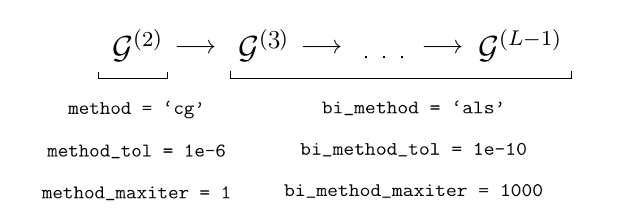

In [12]:
Image("tensor-train-methods.png")

## Epochs

As we can note, there is a flow of information in the tensor train format, the CPD's are computed from left to right, and the next CPD always depend on some information about the previous CPD. Once we compute the CPD of $\mathcal{G}^{(L-1)}$ it is possible to "go back", that is, use the information of the CPD of $\mathcal{G}^{(L-1)}$ to compute a new CPD for $\mathcal{G}^{(L-2)}$, we just have to reverse the way information is propagated. Doing this we may be able to refine all CPD's. These cycles can repeated several times, with the information being propagated forward and backward again and again. Each cycle is called an *epoch*, and the number of epochs can be passed to the program through the parameter *epochs*. Below we redefine the tensor $A$ to have a higher order and try to refine the CPD by using more epochs than just $1$.

In [13]:
# Initialize the sixth-order tensor and compute its CPD with default options.
k = 2
dims = (k+1, k+1, k+1, k+1, k+1, k+1)
L = len(dims)

orig_factors = []
for l in range(L):
    M = np.random.randn(dims[l], k)
    Q, R = np.linalg.qr(M)
    orig_factors.append(Q)
    
A = np.zeros(dims)
A = tfx.cnv.cpd2tens(A, orig_factors, dims)

class options:
    display = -1
    
factors, A_approx, output = tfx.cpd(A, k, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (3, 3, 3, 3, 3, 3) to (2, 2, 2, 2, 2, 2)
    100.0 % of the energy was retained

Total of 4 third order CPDs to be computed:
CPD 1 error = 7.375985435932465e-07
CPD 2 error = 4.849583860632791e-07
CPD 3 error = 4.942428568842458e-16
CPD 4 error = 7.507831298420714e-16

Final results
    Number of steps = 33
    Relative error = 5.557583667042562e-07
    Accuracy =  99.99994 %


In [14]:
# Now we use 5 epochs on the same tensor.
options.epochs = 5
factors, A_approx, output = tfx.cpd(A, k, options)

-----------------------------------------------------------------------------------------------
Computing MLSVD
    Compression detected
    Compressing from (3, 3, 3, 3, 3, 3) to (2, 2, 2, 2, 2, 2)
    100.0 % of the energy was retained

Total of 4 third order CPDs to be computed:
Epoch  1
CPD 1 error = 9.034096629902848e-07
CPD 2 error = 5.122025197216746e-09
CPD 3 error = 3.7041576420030003e-16
CPD 4 error = 3.64253420995276e-15

Epoch  2
CPD 3 error = 5.268938213010524e-15
CPD 2 error = 4.116244138640438e-15
CPD 1 error = 1.402984319652828e-15

Epoch  3
CPD 2 error = 3.276729220608949e-15
CPD 3 error = 3.8365685374240986e-16
CPD 4 error = 3.994254071429177e-16

Epoch  4
CPD 3 error = 7.15743206331985e-16
CPD 2 error = 3.305511337127343e-16
CPD 1 error = 4.1980731633214655e-16

Epoch  5
CPD 2 error = 3.325111324710959e-16
CPD 3 error = 3.7769844270903674e-16
CPD 4 error = 5.359611791901162e-15

Final results
    Number of steps = 12
    Relative error = 2.1740209470099296e-15
    Ac